# Notebook for answering some of the questions set out at the start of my Udacity Data Engineering Nanodegree Project 5: Capstone project 
Aim: show that the chosen data model is suitable to answer the type of questions given in the project summary.

In [1]:
# Import packages
import configparser
import os
import matplotlib.pyplot as plt
import pandas as pd
import pyspark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'
from pyspark.sql import SQLContext
from pyspark import SparkContext

In [2]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['KEY']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['SECRET']

In [3]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [4]:
file_imm = "s3a://ylwbucket2/fact_immigration.parquet/"
df_imm= sqlContext.read.load(file_imm)

In [5]:
df_imm.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ImmigrationVolume: integer (nullable = true)
 |-- SingleCountry: string (nullable = true)
 |-- Year: integer (nullable = true)



In [6]:
file_happy = "s3a://ylwbucket2/happiness.parquet/"
df_happy= sqlContext.read.load(file_happy)

In [7]:
df_happy.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Happiness_Score: float (nullable = true)
 |-- GDP_Score: string (nullable = true)
 |-- Health_Score: string (nullable = true)
 |-- Freedom_Score: string (nullable = true)
 |-- Generosity_Score: string (nullable = true)
 |-- Corruption_Score: string (nullable = true)
 |-- year: integer (nullable = true)



Is there a link between the happiness score and the number of immigrants with that country of birth?

Select for a year, grouped by country for single countries (not regions), the top 10 countries based on immigration volume and display the happiness score for those countries. And also plot the immigration volume versus the happiness score.

In [8]:
year= 2018
sumVolume2018= df_imm.filter((df_imm['year']== year) & (df_imm['SingleCountry']== 'Y')).groupBy(df_imm['Country']).sum('ImmigrationVolume')

In [9]:
sumVolume2018.printSchema()

root
 |-- Country: string (nullable = true)
 |-- sum(ImmigrationVolume): long (nullable = true)



In [10]:
# Countries of birth with total immigrants into NL in 2018 in descending order
imm_2018= sumVolume2018.sort(sumVolume2018['sum(ImmigrationVolume)'].desc())

In [11]:
imm_happy_2018= imm_2018.join(df_happy.filter(df_happy['year']== 2018), imm_2018.Country== df_happy.Country).select(imm_2018.Country, imm_2018['sum(ImmigrationVolume)'], df_happy.Happiness_Score)

In [12]:
imm_happy_2018.show(10)

+--------------+----------------------+---------------+
|       Country|sum(ImmigrationVolume)|Happiness_Score|
+--------------+----------------------+---------------+
|   Netherlands|                 15753|          7.441|
|        Poland|                 14379|          6.123|
|         India|                  6282|           4.19|
|       Romania|                  5063|          5.945|
|       Germany|                  4543|          6.965|
|         Italy|                  3918|            6.0|
|United Kingdom|                  3878|           7.19|
|        Turkey|                  3737|          5.483|
|      Bulgaria|                  3702|          4.933|
|         China|                  3289|          5.246|
+--------------+----------------------+---------------+
only showing top 10 rows



In [13]:
# convert the spark dataframe into a pandas df for plotting
pd2018_imm_happy= imm_happy_2018.toPandas()

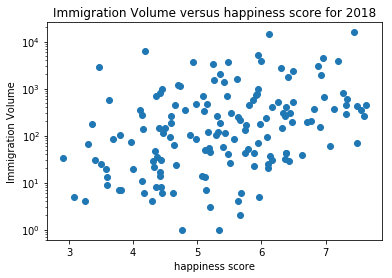

In [14]:
# Plot the total number of immigrants for a country versus the happiness score
plt.scatter(pd2018_imm_happy['Happiness_Score'], pd2018_imm_happy['sum(ImmigrationVolume)'])
plt.xlabel('happiness score')
plt.ylabel('Immigration Volume')
plt.yscale('log')
plt.title('Immigration Volume versus happiness score for 2018');

Observations:
- Country of birth of the highest number of immigrants is The Netherlands itself. This suggests they are people that emigrated before and are now immigrating back into the country. So their immigration is not linked to the happiness score.
- The plot of total Immigration Volume versus Happiness Score is a cloud and there doesn't seem to be a relationship between the two.

What are the demographics of people immigrating into the Netherlands? 

Group the immigration data by age. This can be split by year and/or gender. Calculate the total immigration volume per age and plot this.
By doing this for subsequent years, it can be assessed whether there is a trend in the age of the immigrants.

In [15]:
ImmDemograph2018= df_imm.filter(df_imm['Year']== 2018).groupBy('Age').sum('ImmigrationVolume').withColumnRenamed("sum(ImmigrationVolume)", "sumImmigrationVolume")
ImmDemograph2019= df_imm.filter(df_imm['Year']== 2019).groupBy('Age').sum('ImmigrationVolume').withColumnRenamed("sum(ImmigrationVolume)", "sumImmigrationVolume")
ImmDemograph2020= df_imm.filter(df_imm['Year']== 2020).groupBy('Age').sum('ImmigrationVolume').withColumnRenamed("sum(ImmigrationVolume)", "sumImmigrationVolume")

In [16]:
ImmDemograph2018.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- sumImmigrationVolume: long (nullable = true)



In [17]:
pd_immdemograph2018= ImmDemograph2018.toPandas()

In [18]:
pd_immdemograph2019= ImmDemograph2019.toPandas()

In [19]:
pd_immdemograph2020= ImmDemograph2020.toPandas()

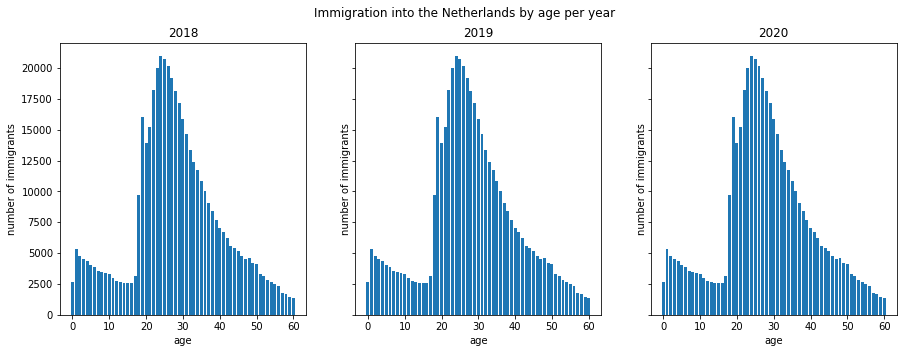

In [37]:
dfs= [pd_immdemograph2018, pd_immdemograph2019, pd_immdemograph2020]
years= [2018, 2019, 2020]
fig, axs = plt.subplots(1, 3, figsize= (15, 5), sharey= True)
for nn, ax in enumerate(axs.flat):
    column= years[nn]
    ax.bar(df['Age'], df['sumImmigrationVolume'])
    #ax.xlabel('age in years')
    ax.set_title(column)
    ax.set_xlabel('age')
    ax.set_ylabel('number of immigrants')
fig.suptitle('Immigration into the Netherlands by age per year')

plt.show();

The demographics are very similar over the period 2018- 2020. So there is no changing trend in the age of immigrants. Most of the immigrants are just under 30 years old. There are none that are older than 60 years. It seems like people immigrated with their children, but - this is based on the decrease in number with age below 18 years old- as their children are older, the children not always immigrate with them.

## Summary:
The above shows that the chosen data model is suitable for the type of questions mentioned in the project summary. Further detailed analysis was not part of the project.